# 1. Import 


In [75]:
# System
import sys
import os
import argparse

# Time
import time
import datetime

# Numerical Data
import random
import numpy as np 
import pandas as pd

# Tools
import shutil
from glob import glob
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing

from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D

# Deep Learning - Keras - Pretrained Models
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge
from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

# Image
from PIL import Image
from IPython.display import display

# np.random.seed(42)




# 2. Functions

In [48]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

# 3. Input Configuration

In [53]:
input_directory = r"../data/cell_images/"
output_directory = r"../output/"

training_dir = input_directory
# testing_dir = input_directory + r"test"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

# 4. Visualization

In [51]:
def plot_image(file, directory=None, sub=False, aspect=None):
    path = directory + file
    
    img = plt.imread(path)
    
    plt.imshow(img, aspect=aspect)
#     plt.title(file)
    plt.xticks([])
    plt.yticks([])
    
    if sub:
        plt.show()
        
def plot_img_dir(directory=training_dir, count=5):
    selected_files = random.sample(os.listdir(directory), count)
    
    ncols = 5
    nrows = count//ncols if count%ncols==0 else count//ncols+1
    
    figsize=(20, ncols*nrows)

    ticksize = 14
    titlesize = ticksize + 8
    labelsize = ticksize + 5


    params = {'figure.figsize' : figsize,
              'axes.labelsize' : labelsize,
              'axes.titlesize' : titlesize,
              'xtick.labelsize': ticksize,
              'ytick.labelsize': ticksize}

    plt.rcParams.update(params)
    
    i=0
    
    for file in selected_files:        
        plt.subplot(nrows, ncols, i+1)
        path = directory + file
        plot_image(file, directory, aspect=None)

        i=i+1
    
    plt.tight_layout()
    plt.show()
    
def plot_img_dir_main(directory=training_dir, count=5):
    labels = os.listdir(directory)
    for label in labels:
        print(label)
        plot_img_dir(directory=directory+"/"+label+"/", count=count)        

Parasitized


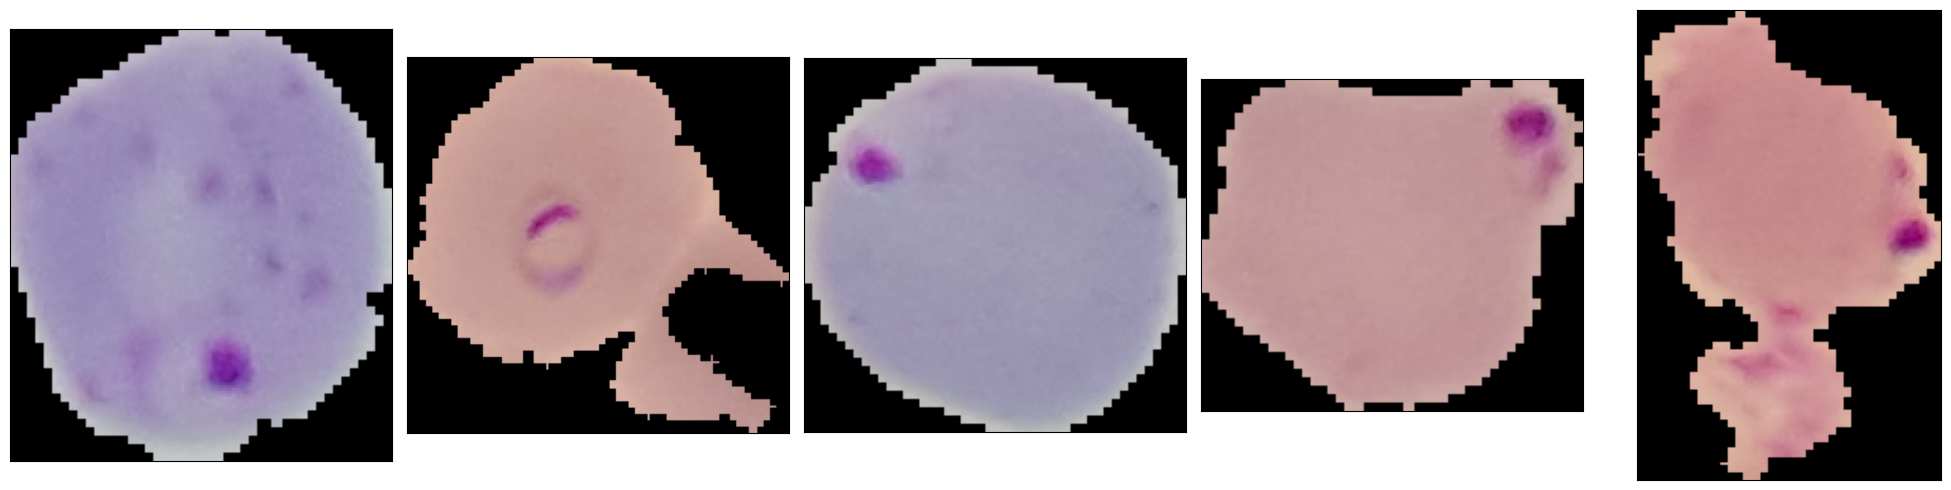

Uninfected


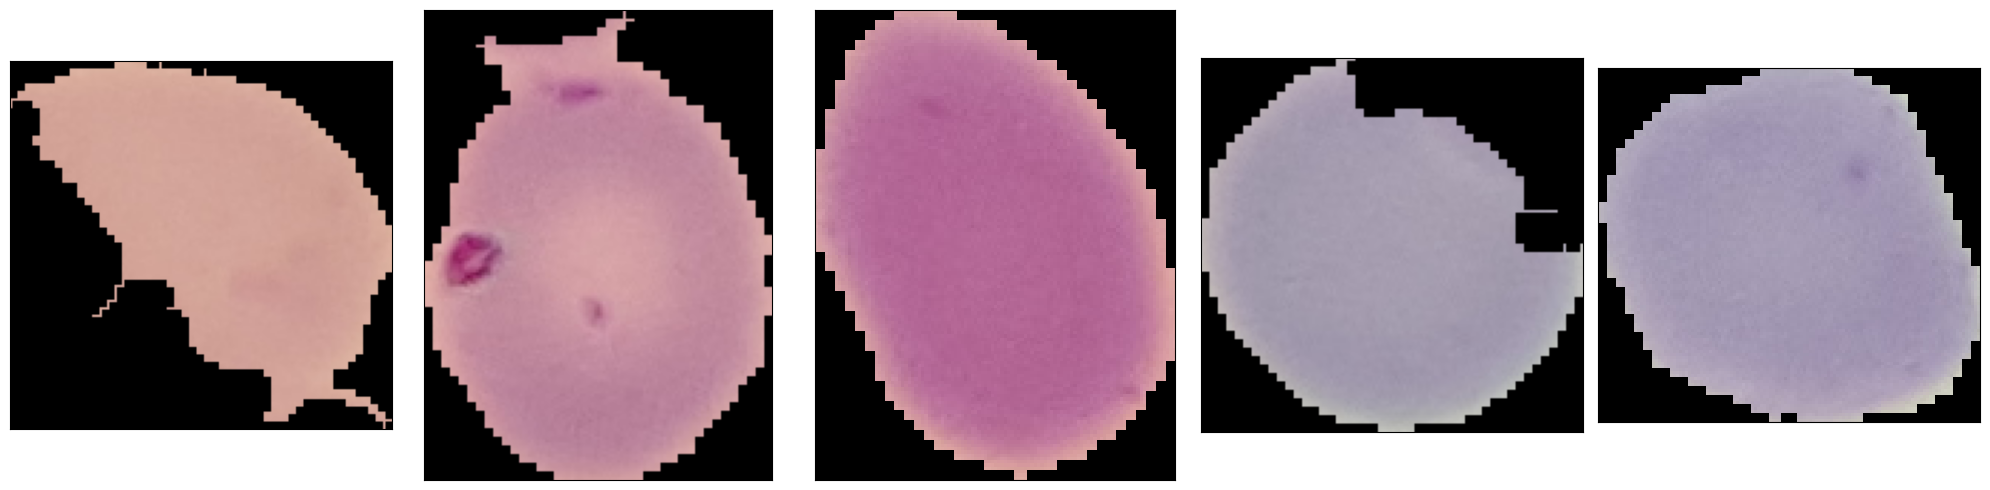

In [54]:

def dir_nohidden(directory):
    ''''
    list directories not hidden (to avoid .DS_store and such when listing dir)
    '''
    dir = []
    for f in os.listdir(directory):
         if not f.startswith('.'):
            dir.append(f)
    return dir
dir_nohidden(training_dir)

plot_img_dir_main(directory=training_dir, count=5)

# 5. Preprocess

#### During Preprocessing, all of the image has been transformed to target size (224, 224) and pixel value has been rescaled to unit value. (224, 224) is the input shape for Pretrained model "NashNetMobile". The target class is treated as categorical and both training and validation image set has been re-shuffled. Some of the images has been horizontally and vertically flipped randomly and sheerness and rotation has been changed to introduce heterogeneity. A part of training dataset has been used as validation set. 

In [81]:
def get_data(batch_size=32, target_size=(299, 299), class_mode="categorical", training_dir=training_dir, testing_dir=None):
    print("Preprocessing and Generating Data Batches.......\n")
    
    rescale = 1.0/255

    train_batch_size = batch_size
    test_batch_size = batch_size
    
    train_shuffle = True
    val_shuffle = True
    test_shuffle = False
    
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=45,
        shear_range=16,
        rescale=rescale,
        validation_split=0.25)

    train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=batch_size, 
        shuffle=True, 
        seed=42,
        subset='training')
    
    validation_generator = train_datagen.flow_from_directory(
        training_dir, 
        target_size=target_size, 
        class_mode=class_mode, 
        batch_size=1024, 
        shuffle=True, 
        seed=42,
        subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=rescale)
    
    test_generator = None
    



    class_weights = get_weight(train_generator.classes)
    # class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
    
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    print("\nPreprocessing and Data Batch Generation Completed.\n")
    
    
    return train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps

# Calculate Class Weights
def get_weight(x):
        class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(x),
                                        y = x
                                        )
        return class_weights
"""def get_weight(y):
    class_weight_current =  compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current"""

"def get_weight(y):\n    class_weight_current =  compute_class_weight('balanced', np.unique(y), y)\n    return class_weight_current"

# 5. Model Function

In [56]:
def get_model(model_name, input_shape=(96, 96, 3), num_class=2):
    inputs = Input(input_shape)
    
    if model_name == "Xception":
        base_model = Xception(include_top=False, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(include_top=False, input_shape=input_shape)
    elif model_name == "InceptionV3":
        # base_model = InceptionV3(include_top=False, input_shape=input_shape)
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == "InceptionResNetV2":
        base_model = InceptionResNetV2(include_top=False, input_shape=input_shape)
    if model_name == "DenseNet201":
        base_model = DenseNet201(include_top=False, input_shape=input_shape)
    if model_name == "NASNetMobile":
        base_model = NASNetMobile(include_top=False, input_shape=input_shape)
    if model_name == "NASNetLarge":
        base_model = NASNetLarge(include_top=False, input_shape=input_shape)
            
#     for layer in base_model.layers:
#         layer.trainable = False
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
    
#     x = base_model(inputs)
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     out = Dense(2, activation="softmax")(x)
#     model = Model(inputs, out)

    x = base_model(inputs)
    
    output1 = GlobalMaxPooling2D()(x)
    output2 = GlobalAveragePooling2D()(x)
    output3 = Flatten()(x)
    
    outputs = Concatenate(axis=-1)([output1, output2, output3])
    
    outputs = Dropout(0.5)(outputs)
    outputs = BatchNormalization()(outputs)
    
    if num_class>1:
        outputs = Dense(num_class, activation="softmax")(outputs)
    else:
        outputs = Dense(1, activation="sigmoid")(outputs)
        
    model = Model(inputs, outputs)
    
    model.summary()
    
    
    return model

# Custom Convolutional Neural Network 
def get_conv_model(num_class=2, input_shape=(3,150,150)):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(num_class , activation='softmax'))

    print(model.summary())
    
    return model


# 6. Output Configuration

In [59]:
main_model_dir = os.path.join(output_directory, 'models/')
main_log_dir = os.path.join(output_directory, 'logs/')

try:
    os.mkdir(main_model_dir)
except:
    print("Could not create main model directory")
    
try:
    os.mkdir(main_log_dir)
except:
    print("Could not create main log directory")



model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')


try:
    os.mkdir(model_dir)
except:
    print("Could not create model directory")
    
try:
    os.mkdir(log_dir)
except:
    print("Could not create log directory")
    
model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

## 6.2 Call Back Configuration

In [60]:
print("Settting Callbacks")

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=1,
    verbose=1)

callbacks = [reduce_lr, early_stopping, checkpoint]

callbacks = [checkpoint, reduce_lr, early_stopping]

print("Set Callbacks at ", date_time(1))
print(callbacks)

Settting Callbacks
Set Callbacks at  Timestamp: 2023-08-22 16:25:23
[<keras.src.callbacks.ModelCheckpoint object at 0x7fcd1a275eb0>, <keras.src.callbacks.ReduceLROnPlateau object at 0x7fcd1a275f70>, <keras.src.callbacks.EarlyStopping object at 0x7fcd18cf2340>]


# 7. Model

In [61]:
print("Getting Base Model", date_time(1))

input_shape = (96, 96, 3)
# input_shape = (224, 224, 3)

num_class = 2


# model = get_model(model_name="NASNetMobile", input_shape=input_shape, num_class=num_class)

model = get_conv_model(input_shape=input_shape)

print("Loaded Base Model", date_time(1))

Getting Base Model Timestamp: 2023-08-22 16:25:26
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 96, 16)        2320      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 48, 48, 16)        0         
                                                                 
 batch_normalization_16 (Ba  (None, 48, 48, 16)        64        
 tchNormalization)                                               
                                                                 
 con

In [62]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [63]:
model_2 = get_model(model_name='NASNetMobile', input_shape=input_shape, num_class=num_class)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 NASNet (Functional)         (None, 3, 3, 1056)           4269716   ['input_9[0][0]']             
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 1056)                 0         ['NASNet[0][0]']              
 obalMaxPooling2D)                                                                                
                                                                                                  
 global_average_pooling2d_2  (None, 1056)                 0         ['NASNet[0][0]']        

In [65]:
loss = 'categorical_crossentropy'
# loss = 'binary_crossentropy'
metrics = ['acc']
# metrics = [auroc]

# 8. Data

In [83]:
# batch_size = 32
batch_size = 176

class_mode = "categorical"
# class_mode = "binary"

# target_size=(96, 96)
target_size=(224, 224)

train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size, target_size=target_size, class_mode=class_mode)

Preprocessing and Generating Data Batches.......

Found 20670 images belonging to 2 classes.
Found 6888 images belonging to 2 classes.

Preprocessing and Data Batch Generation Completed.




# 9. Training

#### Trained model on full tranning dataset for 10 epochs and validated on full validation dataset. Adjusted class weight has been used for trainning. For optimization used Adam optimizer with learning rate of 0.0001. For loss calculation used categorical crossentropy and for model performance evaluation used accuracy metrics.  

In [86]:
print("Starting Trainning ...\n")

start_time = time.time()
print(date_time(1))

# batch_size = 32
# train_generator, validation_generator, test_generator, class_weights, steps_per_epoch, validation_steps = get_data(batch_size=batch_size)

print("\n\nCompliling Model ...\n")
learning_rate = 0.0001
optimizer = Adam(learning_rate)
# optimizer = Adam()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# steps_per_epoch = 180
# validation_steps = 40

verbose = 1
epochs = 10

print("Trainning Model ...\n")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=verbose,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", date_time(1))

Starting Trainning ...

Timestamp: 2023-08-22 16:51:51


Compliling Model ...

Trainning Model ...

Epoch 1/10


ValueError: in user code:

    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 650, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/keras/src/metrics/__init__.py", line 215, in get
        raise ValueError(f"Could not interpret metric identifier: {identifier}")

    ValueError: Could not interpret metric identifier: <module 'sklearn.metrics' from '/Users/alejandroflores/VS_CODE/CNN-Malaria-Detection/malaria-env/lib/python3.9/site-packages/sklearn/metrics/__init__.py'>


# 10. Model Performance 
Model Performance  Visualization over the Epochs

In [14]:
def plot_performance(history=None, figure_directory=None):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    ylim_pad = [0.005, 0.005]
#     ylim_pad = [0, 0]


    plt.figure(figsize=(20, 5))

    # Plot training & validation Accuracy values

    y1 = history.history['acc']
    y2 = history.history['val_acc']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()


    # Plot training & validation loss values

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

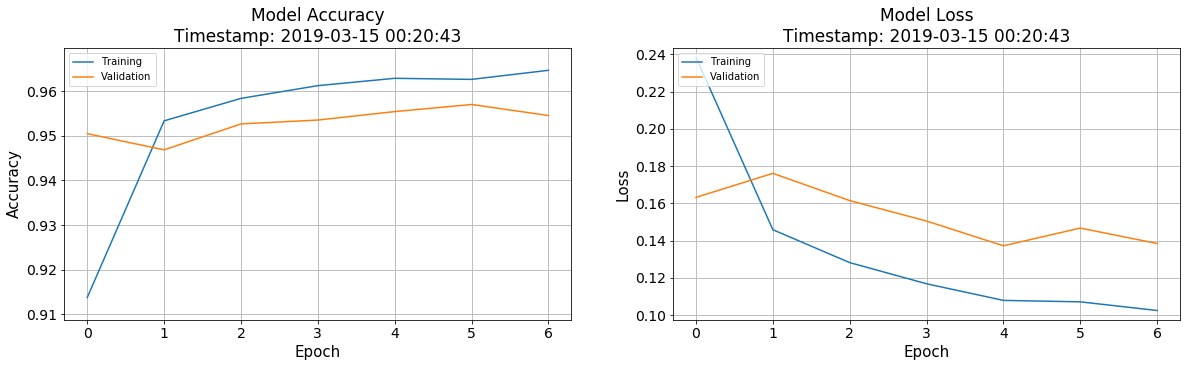

In [15]:
plot_performance(history=history)